In [4]:
import sys
import os

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib as mpl
import seaborn as sns

sys.path.insert(0, '../../')
import ccal
%matplotlib inline
%config InlineBackend.figure_formats = {'svg',}

In [84]:
BLACK = '#000000'
GRAY = '#888888'
SILVER = '#C2C2C2'
WHITE = '#FEFEFE'
MAROON = '#800000'
RED = '#FF0000'
RED_ORANGE = '#EC6313'
ORANGE = '#FFA600'
GOLD = '#EEC727'
YELLOW = '#F6F63C'
GREEN = '#008000'
LIGHT_GREEN = '#69D969'
LIME_GREEN = '#ABFF07'
TEAL = '#05A29F'
AQUA = '#04FFFB'
LIGHT_BLUE = '#04CAFF'
BLUE = '#0411FF'
NAVY = '#0D126E'
LIGHT_PURPLE = '#F0C6FF'
PURPLE = '#800080'
LIGHT_PINK = '#FFC0CB'
PINK = '#FFB3DE'
HOT_PINK = '#FF69B4'
RED_VIOLET = '#C71585'

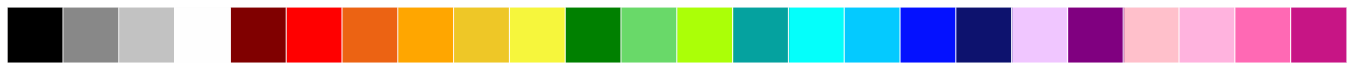

In [86]:
sns.palplot(sns.color_palette([BLACK, GRAY, SILVER, WHITE, MAROON, RED, RED_ORANGE, ORANGE, GOLD, YELLOW, GREEN, LIGHT_GREEN, LIME_GREEN, TEAL, AQUA, LIGHT_BLUE, BLUE, NAVY, LIGHT_PURPLE, PURPLE,  LIGHT_PINK, PINK, HOT_PINK, RED_VIOLET]))